## DATA DOWNLOAD LINK

In [1]:
from urllib import request 
import os
import zipfile

data_name = ['CRC_DX_TRAIN_MSIMUT', 'CRC_DX_TRAIN_MSS', 'CRC_DX_TEST_MSS', 'CRC_DX_TEST_MSIMUT'] 
front_link = 'https://zenodo.org/record/2530835/files/' 
back_link = '.zip?download=1' 

# 폴더 디렉토리 생성 
os.makedirs('/content/TCGA_DATA') 
os.makedirs('/content/TCGA_DATA/CRC_TRAIN') 
os.makedirs('/content/TCGA_DATA/CRC_TEST')

for idx, data_type in enumerate(data_name):
  # 코랩 아니면 아래 경로 수정
  if idx <= 1:
    os.chdir('/content/TCGA_DATA/CRC_TRAIN')
  else:
    os.chdir('/content/TCGA_DATA/CRC_TEST')
  
  link = front_link + data_type + back_link
  request.urlretrieve(link,data_type) 
  zipfile.ZipFile(data_type).extractall()  
  print('One Done')



One Done
One Done
One Done
One Done


## DATA PATH 가져오기 

In [ ]:
from glob import glob
DATA_PATH_TRAIN_LIST = glob('/content/TCGA_DATA/CRC_TRAIN/*/*.png') 
DATA_PATH_TEST_LIST = glob('/content/TCGA_DATA/CRC_TEST/*/*.png')

## Custom DataSet 

In [ ]:
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

class CRC_DataSet(Dataset):
    #data_path_list - 이미지 path 전체 리스트
    #label - 이미지 ground truth
    def __init__(self, data_path_list, classes, transform=None):
        self.path_list = data_path_list
        self.label = []
        for path in data_path_list:
            self.label.append(path.split('/')[-2])
        self.transform = transform
        self.classes = classes
    
    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = io.imread(self.path_list[idx])
        if self.transform is not None:
            image = self.transform(image)
        return image, self.classes.index(self.label[idx])

## Data Loader

In [ ]:
import torch
from torchvision import transforms 

classes = ('MSIMUT', 'MSS')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TRAIN_LIST, 
        classes,
        transform=transform
    ),
    batch_size=4,
    shuffle = True
)

testloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TEST_LIST, 
        classes,
        transform=transform
    ),
    batch_size=4,
    shuffle = False
)

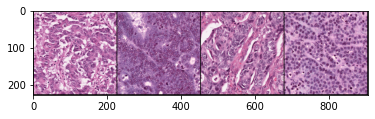

In [ ]:
from matplotlib import pyplot as plt
import torchvision
import numpy as np
dataiter = iter(trainloader)
images, labels = dataiter.next() 
plt.imshow(torchvision.utils.make_grid(images, normalize= True).permute(1,2,0)) 
plt.show()

## Vit Model

In [ ]:
!pip install git+https://github.com/FrancescoSaverioZuppichini/glasses
!pip install huggingface_hub
!pip install torchinfo
!pip install rich
!pip install einops

  Cloning https://github.com/FrancescoSaverioZuppichini/glasses to /tmp/pip-req-build-k_mksbjh
  Running command git clone -q https://github.com/FrancescoSaverioZuppichini/glasses /tmp/pip-req-build-k_mksbjh
  Created wheel for glasses: filename=glasses-0.0.6-py3-none-any.whl size=87657 sha256=2ebaa85c1906bbcac8c8bf328e13ebe6f18697d1637d8ba3ddb7cbf618dba70b
  Stored in directory: /tmp/pip-ephem-wheel-cache-oyqotgpt/wheels/ec/c8/8f/5516a6ff93df7e4a903b3d6028f75dd44c9f4d05e4db9d68e3
Successfully built glasses
     |████████████████████████████████| 61 kB 404 kB/s 
     |████████████████████████████████| 214 kB 5.1 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 


In [ ]:
# 출처 : https://github.com/FrancescoSaverioZuppichini/glasses 
from glasses.models import AutoModel, AutoTransform
model = AutoModel.from_pretrained('vit_large_patch16_224')
cfg = AutoTransform.from_name('vit_large_patch16_224')

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

## Visualization

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


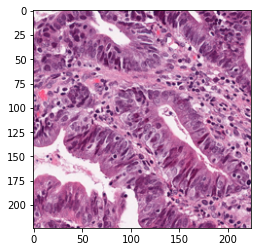

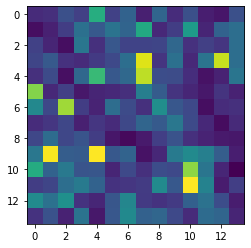

In [ ]:
from glasses.interpretability import GradCam, SaliencyMap
from torchvision.transforms import Normalize
dataiter = iter(trainloader) 
images, labels = dataiter.next() 
plt.imshow(torchvision.utils.make_grid(images[0], normalize= True).permute(1,2,0)) 
_ = model.interpret(images[0].unsqueeze(0), using=SaliencyMap()).show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


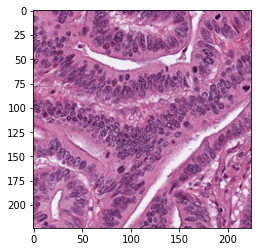

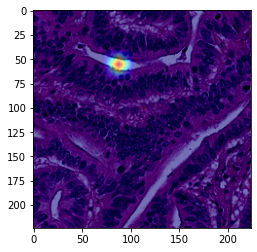

In [ ]:
from glasses.interpretability import GradCam, SaliencyMap
from torchvision.transforms import Normalize
dataiter = iter(trainloader) 
images, labels = dataiter.next() 
plt.imshow(torchvision.utils.make_grid(images[0], normalize= True).permute(1,2,0)) 
_ = model.interpret(images[0].unsqueeze(0), using=GradCam()).show()

In [ ]:
model.summary()

Layer (type:depth-idx)                                  Output Shape              Param #
ViT                                                     --                        --
├─TransformerEncoder: 1                                 --                        --
│    └─ModuleList: 2-1                                  --                        --
├─PatchEmbedding: 1-1                                   [1, 197, 1024]            --
│    └─Sequential: 2-2                                  [1, 196, 1024]            --
│    │    └─Conv2d: 3-1                                 [1, 1024, 14, 14]         787,456
│    │    └─Rearrange: 3-2                              [1, 196, 1024]            --
│    └─ViTTokens: 2-3                                   [1, 1, 1024]              1,024
├─TransformerEncoder: 1-2                               [1, 197, 1024]            --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─TransformerEncoderBlock: 3-3            

## Fine Tuning with Resnet 18

In [ ]:
from glasses.models import ResNet 
import torch.nn.functional as F

In [ ]:
import random
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## HyperParameter


In [ ]:
lr = 0.0001
epochs = 20
batch_size = 400

## Data Loader


In [ ]:
classes = ('MSIMUT', 'MSS')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TRAIN_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = True
)

testloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TEST_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = False
)

## Train Model


In [ ]:
model = ResNet.resnet18(n_classes=2).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.3)

In [ ]:
for epoch in range(epochs):
    avg_cost = 0
    train_loss = 0
    train_total = 0
    train_correct = 0
    model.train()
    for X, Y in trainloader: 
        X = X.to(device)
        Y = Y.to(device) 
        
        optimizer.zero_grad() 

        model_predict  = model(X)
        loss = criterion(model_predict, Y) 
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = model_predict.max(1)
        train_total += Y.size(0) 
        train_correct += predicted.eq(Y).sum().item()
    train_acc = train_correct / train_total
    valid_loss = 0
    valid_total = 0
    valid_correct = 0
    model.eval() 
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    valid_acc = valid_correct / valid_total
    print('[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f' % (epoch, epochs, train_loss, valid_loss, train_acc, valid_acc))

[0/20] TrainLoss: 159.325, ValLoss: 202.463 | TrainAcc: 0.56, ValAcc: 0.43
[1/20] TrainLoss: 144.870, ValLoss: 153.681 | TrainAcc: 0.66, ValAcc: 0.66
[2/20] TrainLoss: 132.976, ValLoss: 425.005 | TrainAcc: 0.70, ValAcc: 0.36
[3/20] TrainLoss: 124.175, ValLoss: 187.699 | TrainAcc: 0.73, ValAcc: 0.71
[4/20] TrainLoss: 118.297, ValLoss: 155.253 | TrainAcc: 0.75, ValAcc: 0.71
[5/20] TrainLoss: 113.615, ValLoss: 203.010 | TrainAcc: 0.76, ValAcc: 0.49
[6/20] TrainLoss: 111.238, ValLoss: 343.229 | TrainAcc: 0.77, ValAcc: 0.41
[7/20] TrainLoss: 106.423, ValLoss: 162.267 | TrainAcc: 0.78, ValAcc: 0.71
[8/20] TrainLoss: 103.878, ValLoss: 203.086 | TrainAcc: 0.79, ValAcc: 0.56
[9/20] TrainLoss: 100.737, ValLoss: 259.719 | TrainAcc: 0.80, ValAcc: 0.47


KeyboardInterrupt: ignored

## CRC_TEST data set에서 MSS 데이터가 MSIMUT 데이터보다 훨씬 많음 여기서 Under Sampling 수행 해봄.

In [ ]:
DATA_PATH_TRAIN_LIST = glob('/content/TCGA_DATA/CRC_TRAIN/*/*.png') 
DATA_PATH_TEST_LIST = glob('/content/TCGA_DATA/CRC_TEST/MSS/*.png')[:28335] + glob('/content/TCGA_DATA/CRC_TEST/MSIMUT/*.png')

In [ ]:
lr = 0.00001
epochs = 30
batch_size = 400

In [ ]:
import torch
from torchvision import transforms 

classes = ('MSIMUT', 'MSS')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TRAIN_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = True
)

testloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TEST_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = True
)

In [ ]:
model = ResNet.resnet18(n_classes=2).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.001)

In [ ]:
for epoch in range(epochs):
    avg_cost = 0
    train_loss = 0
    train_total = 0
    train_correct = 0
    model.train()
    for X, Y in trainloader: 
        X = X.to(device)
        Y = Y.to(device) 
        
        optimizer.zero_grad() 

        model_predict  = model(X)
        loss = criterion(model_predict, Y) 
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = model_predict.max(1)
        train_total += Y.size(0) 
        train_correct += predicted.eq(Y).sum().item()
    train_acc = train_correct / train_total
    valid_loss = 0
    valid_total = 0
    valid_correct = 0
    model.eval() 
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    valid_acc = valid_correct / valid_total
    print('[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f' % (epoch, epochs, train_loss, valid_loss, train_acc, valid_acc))

[0/30] TrainLoss: 156.679, ValLoss: 101.813 | TrainAcc: 0.59, ValAcc: 0.52
[1/30] TrainLoss: 142.420, ValLoss: 108.839 | TrainAcc: 0.67, ValAcc: 0.55
[2/30] TrainLoss: 131.912, ValLoss: 107.242 | TrainAcc: 0.71, ValAcc: 0.56
[3/30] TrainLoss: 123.786, ValLoss: 105.746 | TrainAcc: 0.74, ValAcc: 0.57
[4/30] TrainLoss: 114.066, ValLoss: 108.561 | TrainAcc: 0.77, ValAcc: 0.58
[5/30] TrainLoss: 102.276, ValLoss: 124.541 | TrainAcc: 0.80, ValAcc: 0.55
[6/30] TrainLoss: 85.889, ValLoss: 136.503 | TrainAcc: 0.84, ValAcc: 0.56
[7/30] TrainLoss: 67.610, ValLoss: 173.869 | TrainAcc: 0.89, ValAcc: 0.54
[8/30] TrainLoss: 46.955, ValLoss: 175.404 | TrainAcc: 0.93, ValAcc: 0.56
[9/30] TrainLoss: 30.585, ValLoss: 186.355 | TrainAcc: 0.96, ValAcc: 0.56
[10/30] TrainLoss: 18.774, ValLoss: 211.160 | TrainAcc: 0.99, ValAcc: 0.56
[11/30] TrainLoss: 11.398, ValLoss: 240.278 | TrainAcc: 0.99, ValAcc: 0.56
[12/30] TrainLoss: 6.991, ValLoss: 238.471 | TrainAcc: 1.00, ValAcc: 0.56
[13/30] TrainLoss: 4.804, ValL

In [ ]:
import torch 
torch.save(model.state_dict(), '/content/drive/MyDrive/Resnet18_for_MSIMSS.pt')

## Train data Set 늘리고 실험

In [4]:
from glob import glob
import random
from matplotlib import pyplot as plt
import torchvision
import numpy as np
import torch
from torchvision import transforms 

SEED = 42
random.seed(SEED)

DATA_PATH_TRAIN_LIST = glob('/content/TCGA_DATA/CRC_TRAIN/*/*.png') 

MSS_TEST_LIST = glob('/content/TCGA_DATA/CRC_TEST/MSS/*.png')
random.shuffle(MSS_TEST_LIST)
MSS_TEST_LIST = MSS_TEST_LIST[:28335]
random.shuffle(MSS_TEST_LIST)

MSI_TEST_LIST = glob('/content/TCGA_DATA/CRC_TEST/MSIMUT/*.png')
random.shuffle(MSI_TEST_LIST)  


DATA_PATH_TEST_LIST = MSS_TEST_LIST[:1000] + MSI_TEST_LIST[:1000]
DATA_PATH_TRAIN_LIST += MSS_TEST_LIST[1000:] 
DATA_PATH_TRAIN_LIST += MSI_TEST_LIST[1000:] 


os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
lr = 0.0001
epochs = 40
batch_size = 100

In [6]:
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

class CRC_DataSet(Dataset):
    #data_path_list - 이미지 path 전체 리스트
    #label - 이미지 ground truth
    def __init__(self, data_path_list, classes, transform=None):
        self.path_list = data_path_list
        self.label = []
        for path in data_path_list:
            self.label.append(path.split('/')[-2])
        self.transform = transform
        self.classes = classes
    
    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = io.imread(self.path_list[idx])
        if self.transform is not None:
            image = self.transform(image)
        return image, self.classes.index(self.label[idx])

In [7]:
import torch
from torchvision import transforms 

classes = ('MSIMUT', 'MSS')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TRAIN_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = True
)

testloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TEST_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = True
)

In [3]:
from glasses.models import ResNet 
import torch.nn.functional as F

In [8]:
model = ResNet.resnet50(n_classes= 2).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.1) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10, eta_min=0.00001)

In [2]:
!pip install git+https://github.com/FrancescoSaverioZuppichini/glasses
!pip install huggingface_hub
!pip install torchinfo
!pip install rich
!pip install einops

  Cloning https://github.com/FrancescoSaverioZuppichini/glasses to /tmp/pip-req-build-c_yyb4x5
  Running command git clone -q https://github.com/FrancescoSaverioZuppichini/glasses /tmp/pip-req-build-c_yyb4x5
  Created wheel for glasses: filename=glasses-0.0.6-py3-none-any.whl size=87657 sha256=2a73322de931f1be72149f8f384b895750d0cd8ab154322d09f941e0289fabec
  Stored in directory: /tmp/pip-ephem-wheel-cache-v70vnkxm/wheels/ec/c8/8f/5516a6ff93df7e4a903b3d6028f75dd44c9f4d05e4db9d68e3
Successfully built glasses
     |████████████████████████████████| 61 kB 509 kB/s 
     |████████████████████████████████| 214 kB 5.1 MB/s 
     |████████████████████████████████| 51 kB 9.1 MB/s 


In [ ]:
best_valid_loss = 10000
for epoch in range(epochs):
    avg_cost = 0
    train_loss = 0
    train_total = 0
    train_correct = 0
    model.train()
    for X, Y in trainloader: 
        X = X.to(device)
        Y = Y.to(device) 
        
        optimizer.zero_grad() 

        model_predict  = model(X)
        loss = criterion(model_predict, Y) 
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = model_predict.max(1)
        train_total += Y.size(0) 
        train_correct += predicted.eq(Y).sum().item()
    scheduler.step()
    train_acc = train_correct / train_total
    valid_loss = 0
    valid_total = 0
    valid_correct = 0
    model.eval() 
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    valid_acc = valid_correct / valid_total 
    if best_valid_loss > valid_loss:
      torch.save(model.state_dict(), '/content/drive/MyDrive/resnet50_best_with_lr_schedular.pt') 
      best_valid_loss = valid_loss
    print('[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f' % (epoch, epochs, train_loss, valid_loss, train_acc, valid_acc))

[0/40] TrainLoss: 987.136, ValLoss: 12.564 | TrainAcc: 0.59, ValAcc: 0.65
[1/40] TrainLoss: 853.513, ValLoss: 115.566 | TrainAcc: 0.70, ValAcc: 0.50
[2/40] TrainLoss: 792.753, ValLoss: 17.769 | TrainAcc: 0.73, ValAcc: 0.48
[3/40] TrainLoss: 749.351, ValLoss: 13.696 | TrainAcc: 0.75, ValAcc: 0.55
[4/40] TrainLoss: 698.842, ValLoss: 11.089 | TrainAcc: 0.77, ValAcc: 0.76
[5/40] TrainLoss: 642.002, ValLoss: 13.218 | TrainAcc: 0.79, ValAcc: 0.62
[6/40] TrainLoss: 586.210, ValLoss: 9.742 | TrainAcc: 0.82, ValAcc: 0.76
[7/40] TrainLoss: 533.300, ValLoss: 8.730 | TrainAcc: 0.84, ValAcc: 0.81
[8/40] TrainLoss: 481.545, ValLoss: 17.724 | TrainAcc: 0.86, ValAcc: 0.60
[9/40] TrainLoss: 440.957, ValLoss: 5.611 | TrainAcc: 0.87, ValAcc: 0.89
[10/40] TrainLoss: 415.884, ValLoss: 11.980 | TrainAcc: 0.88, ValAcc: 0.78
[11/40] TrainLoss: 412.506, ValLoss: 8.848 | TrainAcc: 0.88, ValAcc: 0.83
[12/40] TrainLoss: 428.057, ValLoss: 8.157 | TrainAcc: 0.87, ValAcc: 0.81
[13/40] TrainLoss: 457.171, ValLoss: 7.

KeyboardInterrupt: ignored

In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Deep tuning with Best Model

In [8]:
best_model = ResNet.resnet50(n_classes= 2).to(device)

In [9]:
best_model.load_state_dict(torch.load('/content/drive/MyDrive/resnet50_the_best.pt'))

<All keys matched successfully>

In [13]:
lr = 0.0001
epochs = 20
batch_size = 10

In [14]:
import torch
from torchvision import transforms 

classes = ('MSIMUT', 'MSS')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TRAIN_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = True
)

testloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TEST_LIST, 
        classes,
        transform=transform
    ),
    batch_size=batch_size,
    shuffle = True
)

In [15]:
criterion = torch.nn.CrossEntropyLoss().to(device)  
optimizer = torch.optim.Adam(best_model.parameters(), lr= lr, weight_decay=0.1) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience= 3, mode = 'min')

In [16]:
best_valid_loss = 10000
for epoch in range(epochs):
    avg_cost = 0
    train_loss = 0
    train_total = 0
    train_correct = 0
    best_model.train()
    for X, Y in trainloader: 
        X = X.to(device)
        Y = Y.to(device) 
        
        optimizer.zero_grad() 

        model_predict  = best_model(X)
        loss = criterion(model_predict, Y) 
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = model_predict.max(1)
        train_total += Y.size(0) 
        train_correct += predicted.eq(Y).sum().item()
    train_acc = train_correct / train_total
    valid_loss = 0
    valid_total = 0
    valid_correct = 0
    best_model.eval() 
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            loss = F.cross_entropy(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
    valid_acc = valid_correct / valid_total 
    torch.save(best_model.state_dict(), '/content/drive/MyDrive/resnet50_the_best.pt') 
    print('[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f' % (epoch, epochs, train_loss, valid_loss, train_acc, valid_acc))
    scheduler.step(valid_loss)

[0/20] TrainLoss: 661.809, ValLoss: 9.578 | TrainAcc: 0.81, ValAcc: 0.78
[1/20] TrainLoss: 632.778, ValLoss: 9.083 | TrainAcc: 0.82, ValAcc: 0.80
[2/20] TrainLoss: 610.243, ValLoss: 15.231 | TrainAcc: 0.83, ValAcc: 0.61
[3/20] TrainLoss: 601.005, ValLoss: 9.181 | TrainAcc: 0.83, ValAcc: 0.78
[4/20] TrainLoss: 589.937, ValLoss: 11.855 | TrainAcc: 0.84, ValAcc: 0.67
[5/20] TrainLoss: 581.661, ValLoss: 9.303 | TrainAcc: 0.84, ValAcc: 0.79
[6/20] TrainLoss: 503.409, ValLoss: 7.045 | TrainAcc: 0.88, ValAcc: 0.86
[7/20] TrainLoss: 478.480, ValLoss: 6.096 | TrainAcc: 0.88, ValAcc: 0.89
[8/20] TrainLoss: 467.006, ValLoss: 6.477 | TrainAcc: 0.88, ValAcc: 0.87
[9/20] TrainLoss: 459.940, ValLoss: 5.917 | TrainAcc: 0.89, ValAcc: 0.90
[10/20] TrainLoss: 454.804, ValLoss: 7.019 | TrainAcc: 0.89, ValAcc: 0.85
[11/20] TrainLoss: 449.446, ValLoss: 6.225 | TrainAcc: 0.89, ValAcc: 0.88
[12/20] TrainLoss: 443.907, ValLoss: 5.847 | TrainAcc: 0.89, ValAcc: 0.90
[13/20] TrainLoss: 441.448, ValLoss: 6.131 | T

In [17]:
len(testloader)

20

In [17]:
valid_loss = 0
valid_total = 0
valid_correct = 0
for inputs, labels in testloader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = best_model(inputs)
  loss = F.cross_entropy(outputs, labels)
  valid_loss += loss.item()
  _, predicted = torch.max(outputs.data, 1)
  valid_total += labels.size(0)
  valid_correct += (predicted == labels).sum().item()
valid_acc = valid_correct / valid_total 

In [20]:
valid_acc

0.848

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


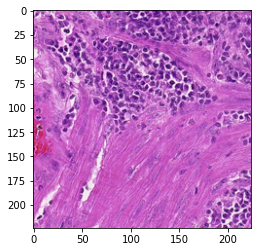

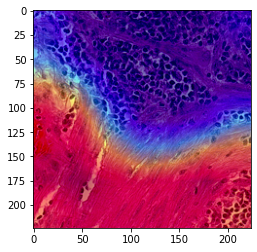

In [70]:
from glasses.interpretability import GradCam, SaliencyMap
from torchvision.transforms import Normalize
dataiter = iter(trainloader) 
images, labels = dataiter.next() 
plt.imshow(torchvision.utils.make_grid(images[0], normalize= True).permute(1,2,0)) 
_ = best_model.interpret(images[0].to(device).unsqueeze(0), using=GradCam()).show()

In [72]:
output = best_model(images.to(device)) 
_, predicted = torch.max(output.data, 1)
print('실제 라벨: {} , 예측 라벨: {}'.format(labels[0], predicted[0]))

실제 라벨: 1 , 예측 라벨: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
